<a href="https://colab.research.google.com/github/AKookani/NLP/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers
!pip install -q sparknlp
!pip install -q gdown
!pip install -q hazm
!pip install -q clean-text[gpl]
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.3/636.3 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 20.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
pymc 5.19.1 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Download the DigiMag dataset
!gdown "https://drive.google.com/uc?id=1YgrCYY-Z0h2z0-PfWVfOGt1Tv0JDI-qz"

# Verify the download
!ls

Downloading...
From: https://drive.google.com/uc?id=1YgrCYY-Z0h2z0-PfWVfOGt1Tv0JDI-qz
To: /content/digimag.zip
100% 13.6M/13.6M [00:00<00:00, 16.9MB/s]
digimag.zip  sample_data


In [3]:
import zipfile

with zipfile.ZipFile("digimag.zip", 'r') as zip_ref:
    zip_ref.extractall(".")  # Extract to the current directory

In [4]:
import pandas as pd

# Load the CSV files into pandas dataframes, specifying the delimiter and setting the first column as index
dev_data = pd.read_csv("/content/digimag/dev.csv", delimiter='\t')
test_data = pd.read_csv("/content/digimag/test.csv", delimiter='\t')
train_data = pd.read_csv("/content/digimag/train.csv", delimiter='\t')

In [5]:
from hazm import Normalizer
from cleantext import clean
import re

# Initialize the Normalizer
normalizer = Normalizer()

# Preprocessing function
def preprocess_text(text):
    # Remove unnecessary punctuation marks
    text = re.sub(r'[\"#$%&\'()*+/:;<=>@[\\]^_`{|}~]', '', text)

    # Convert Arabic characters to Persian equivalents
    text = text.replace("ي", "ی").replace("ك", "ک")

    # Normalize text to standardize the font format
    text = normalizer.normalize(text)

    # Clean the text to remove extra spaces, unwanted characters
    text = clean(
        text,
        fix_unicode=True,        # Replace broken unicode characters
        to_ascii=False,          # Do not convert to ASCII
        lower=False,             # Keep the original casing
        no_line_breaks=True,     # Remove line breaks
        no_urls=True,            # Remove URLs
        no_emails=True,          # Remove email addresses
        no_phone_numbers=True,   # Remove phone numbers
        no_numbers=False,        # Keep numbers
        no_digits=False,         # Keep digits
        no_currency_symbols=True # Remove currency symbols
    )

    return text

train_data.rename(columns={train_data.columns[1]: 'text'}, inplace=True)
dev_data.rename(columns={dev_data.columns[1]: 'text'}, inplace=True)
test_data.rename(columns={test_data.columns[1]: 'text'}, inplace=True)


# Apply preprocessing to the datasets
def preprocess_dataframe(df, text_column):
    df[text_column] = df[text_column].apply(preprocess_text)
    return df

# Preprocess the train, dev, and test datasets
train_data = preprocess_dataframe(train_data, text_column="text")
dev_data = preprocess_dataframe(dev_data, text_column="text")
test_data = preprocess_dataframe(test_data, text_column="text")

In [6]:
train_data.head()

,Unnamed: 0,text,label,label_id
0,0,نمایش تبلیغ در لاک‌اسکرین تعدادی از گوشی‌های ه...,علم و تکنولوژی,3
1,1,شکست Justice League در باکس آفیس پس از بازخورد...,هنر و سینما,5
2,2,کلاسیک بینی؛ همه چیز در یک شب اتفاق افتاد فیلم...,هنر و سینما,5
3,3,اپل دوباره سراغ رنده رفته چراکه آپگرید کردن سط...,علم و تکنولوژی,3
4,4,بررسی جزء به جزء بهترین بخش Ori and the Blind ...,بازی ویدیویی,0


In [7]:
dev_data.head()

,Unnamed: 0,text,label,label_id
0,0,نت‌فلیکس مجموعه‌ی سریالی کسلوانیا را می‌سازد [...,هنر و سینما,5
1,1,کارگردان The Last Guardian از بازی بعدی‌اش می‌...,بازی ویدیویی,0
2,2,کارت اعتباری اپل کارت معرفی شد در مراسم Show T...,علم و تکنولوژی,3
3,3,از کنفرانس مایکروسافت و کنسول بعدی سونی تا دیگ...,بازی ویدیویی,0
4,4,از رویداد ماه اکتبر اپل چه انتظاراتی داریم؟ در...,علم و تکنولوژی,3


In [8]:
test_data.head()

,Unnamed: 0,text,label,label_id
0,0,با این ۵ صبحانه رژیمی لاغر شوید صبحانه همیشه ب...,سلامت و زیبایی,2
1,1,نمایشگر گوشی تاشونده ال‌جی مانند بروشور باز و ...,علم و تکنولوژی,3
2,2,چرا برخی سلبریتی‌های هالیوودی از شبکه‌های اجتم...,هنر و سینما,5
3,3,گوگل استیدیا؛ آینده‌ی صنعت بازی یا محکوم به شک...,بازی ویدیویی,0
4,4,ویژگی جذاب گلکسی Z Flip به زودی به گوشی‌های ان...,علم و تکنولوژی,3


Label Distribution for Train Data:
label
علم و تکنولوژی    2245
بازی ویدیویی      1593
هنر و سینما       1350
سلامت و زیبایی    1304
کتاب و ادبیات      206
راهنمای خرید       101
عمومی               97
Name: count, dtype: int64


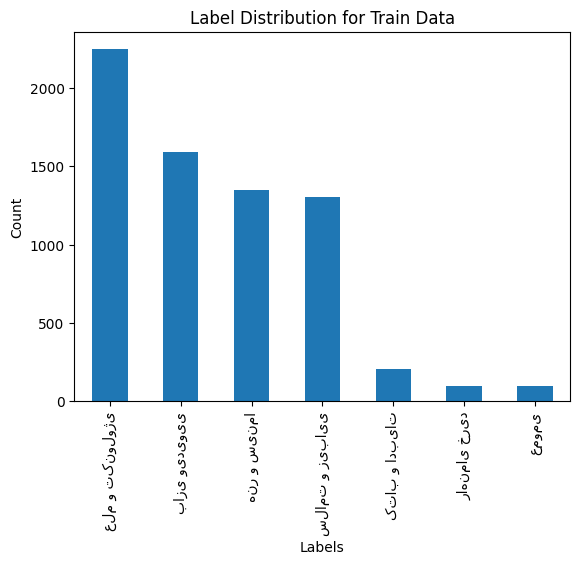

Label Distribution for Dev Data:
label
علم و تکنولوژی    250
بازی ویدیویی      177
هنر و سینما       150
سلامت و زیبایی    145
کتاب و ادبیات      23
عمومی              11
راهنمای خرید       11
Name: count, dtype: int64


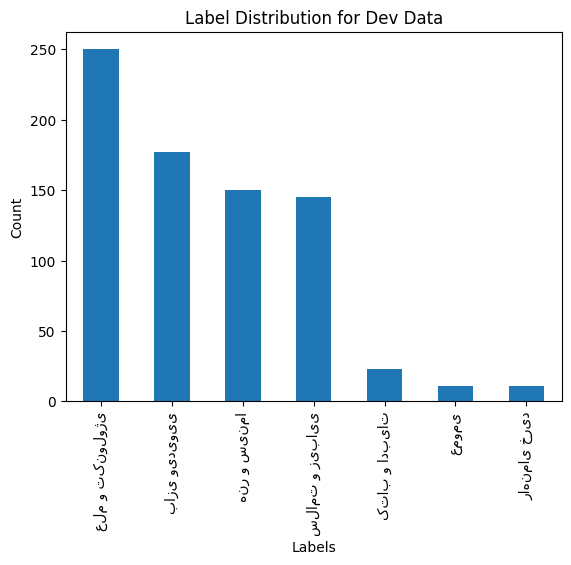

Label Distribution for Test Data:
label
علم و تکنولوژی    277
بازی ویدیویی      197
هنر و سینما       167
سلامت و زیبایی    161
کتاب و ادبیات      25
راهنمای خرید       13
عمومی              12
Name: count, dtype: int64


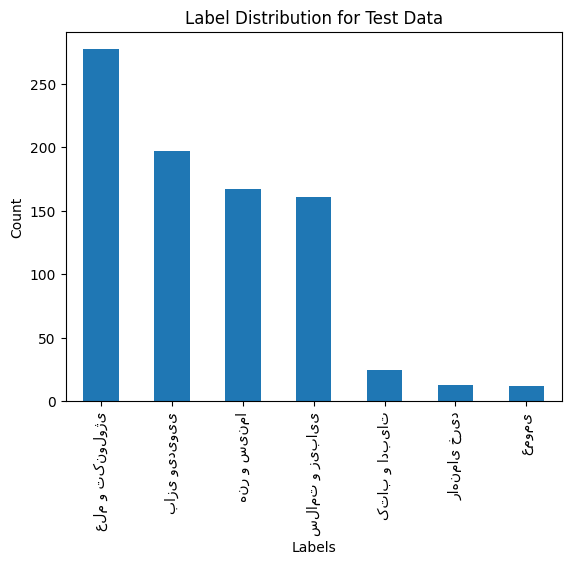

Balancing training data...
Balanced dataset sample size per label: 97
Label Distribution for Balanced Train Data:
label
بازی ویدیویی      97
راهنمای خرید      97
سلامت و زیبایی    97
علم و تکنولوژی    97
عمومی             97
هنر و سینما       97
کتاب و ادبیات     97
Name: count, dtype: int64


<ipython-input-9-d1f13d5c5fed>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_column).apply(lambda x: x.sample(min_count)).reset_index(drop=True)


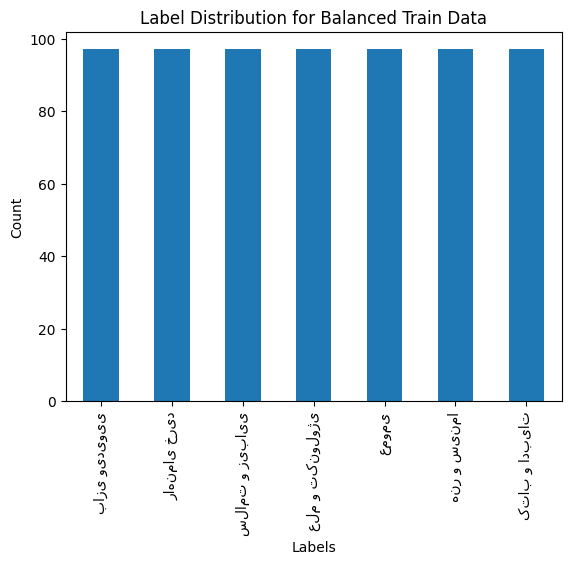

In [9]:
import matplotlib.pyplot as plt

# Analyze label distribution
def plot_label_distribution(df, label_column, title):
    label_counts = df[label_column].value_counts()
    print(f"Label Distribution for {title}:")
    print(label_counts)
    label_counts.plot(kind='bar')
    plt.title(f"Label Distribution for {title}")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.show()
    return label_counts

# Plot distributions for train, dev, and test data
train_label_dist = plot_label_distribution(train_data, label_column="label", title="Train Data")
dev_label_dist = plot_label_distribution(dev_data, label_column="label", title="Dev Data")
test_label_dist = plot_label_distribution(test_data, label_column="label", title="Test Data")

# Balancing the dataset
def balance_dataset(df, label_column):
    min_count = df[label_column].value_counts().min()
    balanced_df = df.groupby(label_column).apply(lambda x: x.sample(min_count)).reset_index(drop=True)
    print(f"Balanced dataset sample size per label: {min_count}")
    return balanced_df

# Balance the training dataset if necessary
if train_label_dist.min() != train_label_dist.max():
    print("Balancing training data...")
    train_data = balance_dataset(train_data, label_column="label")
    plot_label_distribution(train_data, label_column="label", title="Balanced Train Data")
else:
    print("Training data is already balanced.")

In [10]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Ensure labels are numeric
train_data['label'] = label_encoder.fit_transform(train_data['label'])
dev_data['label'] = label_encoder.fit_transform(dev_data['label'])
test_data['label'] = label_encoder.fit_transform(test_data['label'])

In [11]:
# Check dataset sizes
print(f"Train dataset size: {len(train_data['label'])}")
print(f"Dev dataset size: {len(dev_data['label'])}")
print(f"Test dataset size: {len(test_data['label'])}")

# Check for NaN or empty values in the label column before converting to Dataset
print("Checking for NaNs or empty values in label column...")
print(f"Train NaNs: {train_data['label'].isna().sum()}")
print(f"Dev NaNs: {dev_data['label'].isna().sum()}")
print(f"Test NaNs: {test_data['label'].isna().sum()}")

# Ensure datasets are not empty after conversion
if len(train_data) == 0:
    print("Error: Train dataset is empty after preprocessing and conversion.")
if len(dev_data) == 0:
    print("Error: Dev dataset is empty after preprocessing and conversion.")
if len(test_data) == 0:
    print("Error: Test dataset is empty after preprocessing and conversion.")

Train dataset size: 679
Dev dataset size: 767
Test dataset size: 852
Checking for NaNs or empty values in label column...
Train NaNs: 0
Dev NaNs: 0
Test NaNs: 0


In [14]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Check device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert the pandas dataframe to the Hugging Face Dataset format
def convert_to_dataset(df, text_column, label_column):
    return Dataset.from_pandas(df[[text_column, label_column]])

train_dataset = convert_to_dataset(train_data, text_column="text", label_column="label")
dev_dataset = convert_to_dataset(dev_data, text_column="text", label_column="label")
test_dataset = convert_to_dataset(test_data, text_column="text", label_column="label")

# Tokenize the datasets
# Removed .to(device) as tokenizers don't need to be moved to a specific device.
tokenizer = AutoTokenizer.from_pretrained("ViraIntelligentDataMining/AriaBERT")
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
dev_dataset = dev_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Prepare datasets for PyTorch (convert labels to integers)
train_dataset = train_dataset.rename_column("label", "labels").with_format("torch")
dev_dataset = dev_dataset.rename_column("label", "labels").with_format("torch")
test_dataset = test_dataset.rename_column("label", "labels").with_format("torch")

# Load pre-trained model for sequence classification
# The model should be moved to the device
model = AutoModelForSequenceClassification.from_pretrained(
    "ViraIntelligentDataMining/AriaBERT", num_labels=len(train_data["label"].unique())
).to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_ariabert")
tokenizer.save_pretrained("./fine_tuned_ariabert")

Using device: cuda


Map:   0%|          | 0/679 [00:00<?, ? examples/s]

Map:   0%|          | 0/767 [00:00<?, ? examples/s]

Map:   0%|          | 0/852 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ViraIntelligentDataMining/AriaBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-14-4b7f1753ea97>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.345200,1.116178
2,0.900300,0.666810
3,0.655500,0.607168


('./fine_tuned_ariabert/tokenizer_config.json',
 './fine_tuned_ariabert/special_tokens_map.json',
 './fine_tuned_ariabert/vocab.json',
 './fine_tuned_ariabert/merges.txt',
 './fine_tuned_ariabert/added_tokens.json',
 './fine_tuned_ariabert/tokenizer.json')

In [17]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define a function to evaluate the model on the test dataset
def evaluate_model(trainer, test_dataset):
    # Get predictions
    predictions, labels, _ = trainer.predict(test_dataset)
    predictions = np.argmax(predictions, axis=1)

    # Get unique labels from the test dataset
    unique_labels = sorted(set(labels.tolist()))
    label_names = [str(label) for label in unique_labels]  # Convert labels to strings for classification_report

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    report = classification_report(labels, predictions, target_names=label_names)

    print(f"Accuracy: {accuracy:.4f}")
    print("\nDetailed Classification Report:")
    print(report)
    return accuracy, report

# Evaluate the model
print("Evaluating the fine-tuned AriaBERT model on the test dataset...")
accuracy, report = evaluate_model(trainer, test_dataset)

# Save the evaluation results to a file
with open("evaluation_results.txt", "w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n\n")
    f.write("Detailed Classification Report:\n")
    f.write(report)

Evaluating the fine-tuned AriaBERT model on the test dataset...


Accuracy: 0.8638

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       197
           1       0.29      1.00      0.45        13
           2       0.92      0.75      0.83       161
           3       0.94      0.92      0.93       277
           4       0.14      0.42      0.21        12
           5       0.95      0.83      0.89       167
           6       0.56      0.96      0.71        25

    accuracy                           0.86       852
   macro avg       0.68      0.83      0.71       852
weighted avg       0.92      0.86      0.88       852

